In [1]:
import numpy as np
from simulator.csad import CSAD_DP_6DOF
from Observer.EKF import EKF


dt = 0.01
N = 10000

system = CSAD_DP_6DOF(dt)
KalmanFilter = EKF(dt, system._M, system._D)


storage_state = np.zeros((N,13))
storage_observer = np.zeros((N, 15))

x = np.zeros(15)
np.random.seed(1234)

for i in range(N):
    # time
    t = (i+1)*system._dt

    # Thruster forces
    tau = np.array([10*np.sin(t),0,0,0,0,0])

    # Env. forces
    # = 0

    # Calculate x_dot and integrate
    system.x_dot(.5, np.deg2rad(60), tau)                   # U, beta, tau
    system.integrate()

    # Measurement
    y = np.array(system.get_eta() + np.random.normal(0, .5, size=6))
    y_obs = np.array([y[0], y[1], y[5]])

    # Observer
    KalmanFilter.corrector(y_obs)
    KalmanFilter.predictor(np.array([tau[0], tau[1], tau[5]]))

    # Controller
    # = 0
    x_hat = KalmanFilter._xhat
    

    # Save for storage
    storage_state[i] = np.concatenate([t, system.get_eta(),y], axis=None)
    storage_observer[i] = x_hat


t = storage_state[:,0]
eta = storage_state[:,1:7]
y = storage_state[:,7:13]

xi_hat = storage_observer[:,0:6]
eta_hat = storage_observer[:,6:9]
b_hat = storage_observer[:,9:12]
nu_hat = storage_observer[:,12:15]



C:\Users\Haral\OneDrive\Dokumenter\NTNU\9. semester\Prosjektoppgave\Simuleringsmodell_med_Jan\Wave-Model\Observer\EKF.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ax1 = np.array(


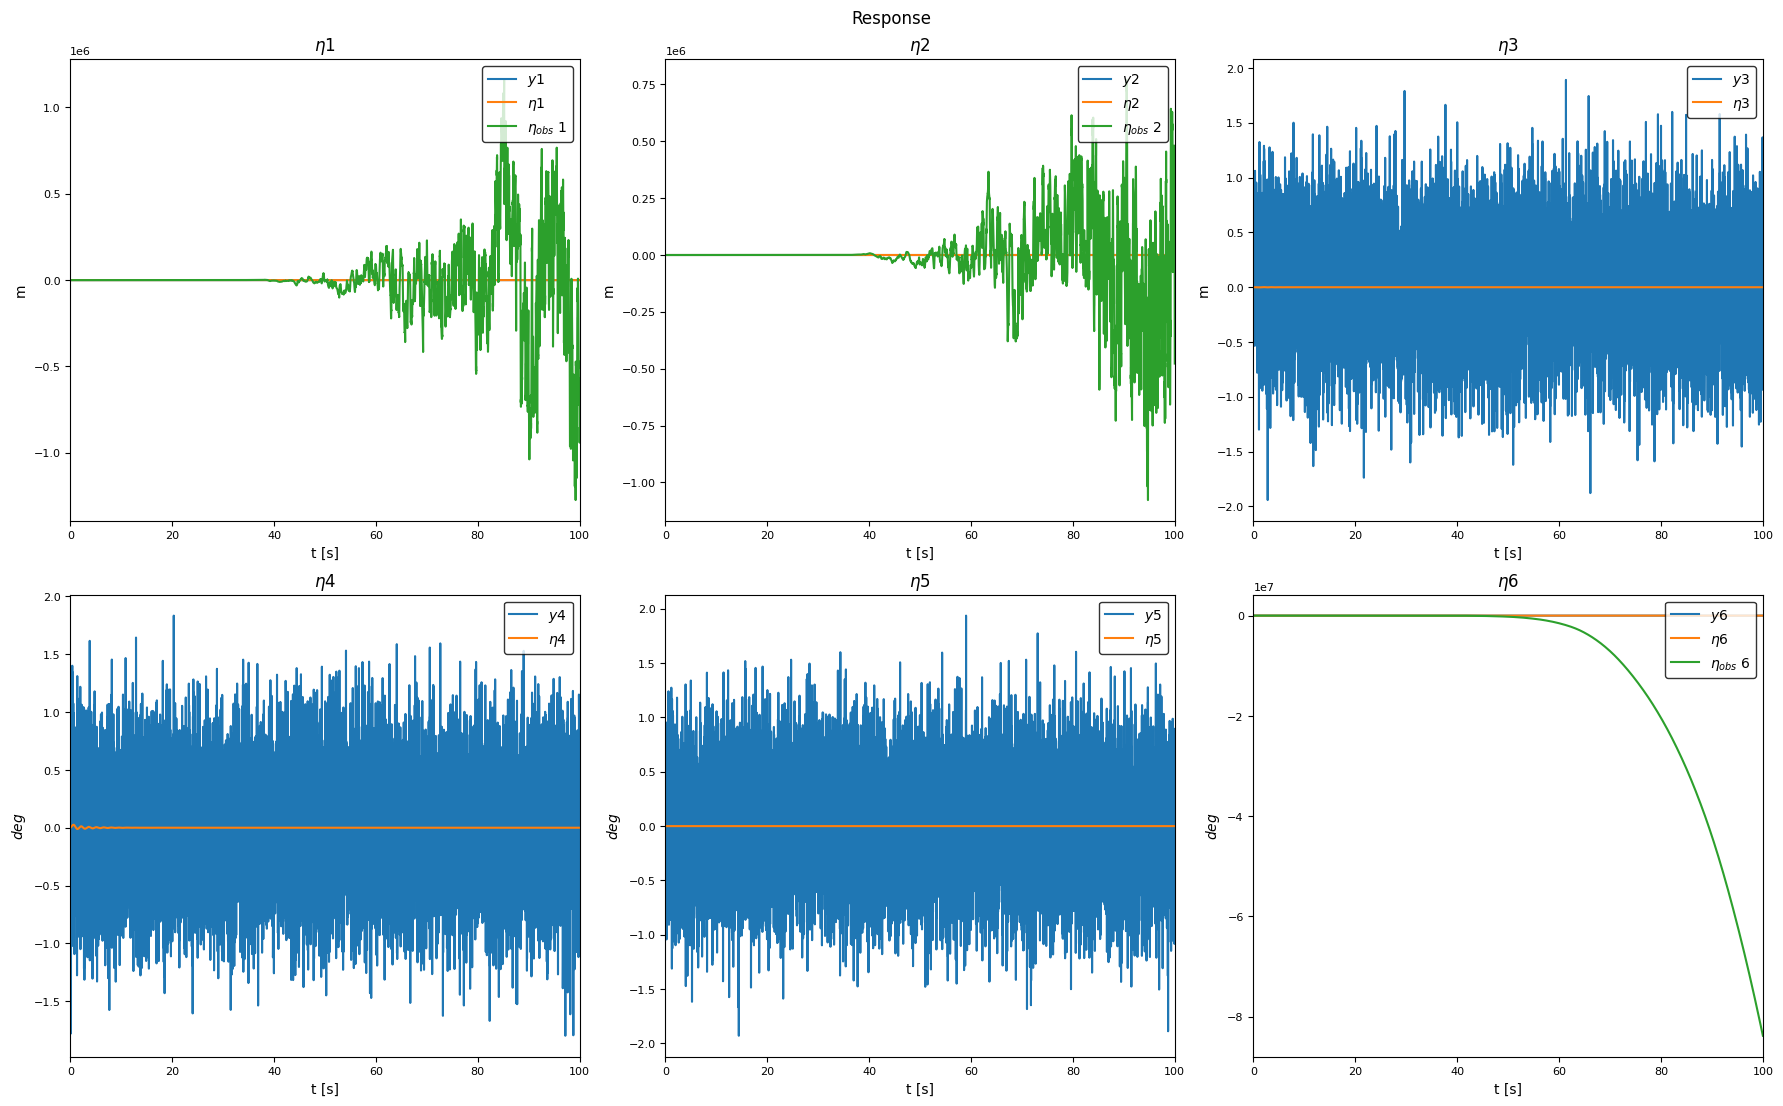

In [3]:
# Results
import matplotlib.pyplot as plt

# Set up the plotting parameters. ------------------------------------------
width = 426.8*3       # Latex document width in pts
inch_pr_pt = 1/72.27        # Ratio between pts and inches
golden_ratio = (np.sqrt(5) - 1)/2
fig_width = width*inch_pr_pt
fig_height = fig_width*golden_ratio
fig_size = [fig_width, fig_height]
params = {#'backend': 'PS',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'axes.grid': True,
          #'text.usetex': True,
          'figure.constrained_layout.use': True,
          'figure.figsize': fig_size
          } 
plt.rcParams.update(params)


# Plot response --------------------------------------------------------------
fig, axs = plt.subplots(2, 3)
i_obs=0
for i in range(2):
    for j in range(3):
        DOF = j+1+3*i
        axs[i,j].plot(t, y[:,DOF-1], label=r'$y$'+str(DOF))
        axs[i,j].plot(t, eta[:, DOF-1], label=r'$\eta$'+str(DOF))
        axs[i,j].grid()
        axs[i,j].set_xlim([0,dt*N])
        axs[i,j].set_xlabel('t [s]')
        axs[i,j].set_title(r'$\eta $'  + str(DOF))
        if i == 1:
            axs[i,j].set_ylabel(r'$deg$')
        else:
            axs[i,j].set_ylabel('m')  
        if DOF in [1,2,6]: 
            axs[i,j].plot(t, eta_hat[:,i_obs], label=r'$\eta_{obs} $ '+str(DOF))
            i_obs+=1
        
        axs[i,j].legend(loc="upper right", edgecolor="k")

plt.tight_layout()
plt.suptitle('Response')
plt.show()